# Generative data

The goal here is to simulate data under a generative model and then to assess the ability of our probabilistic models to estimate the correct parameter values in their posteriors.

We fit a hierarchical linear model in pymc3 as in:

- [https://twiecki.io/blog/2014/03/17/bayesian-glms-3/](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/)  
- [https://discourse.pymc.io/t/help-with-censored-regression/4617/21](https://discourse.pymc.io/t/help-with-censored-regression/4617/21)  
- [https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html](https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html)

In [372]:
# conda install toytree pymc3 -c conda-forge

In [373]:
import itertools
import pandas as pd
import numpy as np
import toytree
import toyplot
import pymc3 as pm
import theano

In [374]:
toyplot.config.autoformat = "png"

### The phylogeny
We will simulate data on a phylogeny with four clades that have different rates of evolution of reproductive incompatibility, colored below. 

In [450]:
# generate a random tree
NSPECIES = 80
TREE = toytree.rtree.bdtree(
    ntips=NSPECIES,
    seed=666,
).mod.node_scale_root_height(1.0)

In [453]:
# node idxs that delimit several distinct clades on this tree
CLADES = [152, 153, 154, 155]

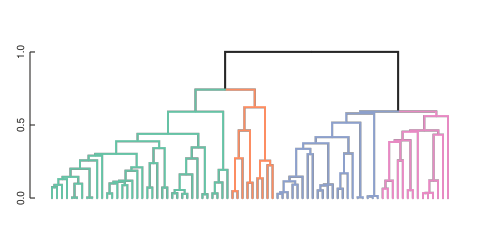

In [465]:
# draw and color the four major clades
TREE.draw(
    layout='d', 
    width=500,
    tip_labels=False,
    edge_colors=TREE.get_edge_values_mapped({
        j: toytree.colors[i] for i, j in enumerate(CLADES)
    }),
    scalebar=True,
);

In [467]:
# ntips in each clade 
GROUP_SIZE = {i: len(TREE.idx_dict[j]) for i, j in enumerate(CLADES)}

# Numeric assignment of tips to groups
GROUPS = np.concatenate(
    [np.repeat(i, GROUP_SIZE[i]) for i in GROUP_SIZE]
)

### Logistic model of RI with time

We will model incompatibility as something that accumulates linearly with time since divergence, with the rate parameter varying among the four clades. The question is: "does genetic distance predict the level of genetic incompatibility between species?". To implement a hierarchical model we are additionally asking: "Does information about which clade the species is from improve estimation?"


$$ Y_{ij} = \frac{1}{1 + exp^{-(\alpha + (\beta + \psi_i + \psi_j)X_{ij})}} $$

$\alpha$ = intercept    
$\beta$ = base RI velocity  
$X_{ij}$ = genetic divergence  
$Y_{ij}$  = Reproductive incompatibility  
$\psi$ = species RI velocity  

In [662]:
# True param values
𝛼_mean = 0.05
𝛼_std = 0.02
𝛽_mean = 3.0
𝛽_std = 0.2

In [663]:
# 4 different clade effects on rate of RI (used for partial-pooling data)
𝜓_0_mean = 1.0
𝜓_0_std = 0.1
𝜓_1_mean = 0.5
𝜓_1_std = 0.05
𝜓_2_mean = -0.5
𝜓_2_std = 0.05
𝜓_3_mean = -1.0
𝜓_3_std = 0.1

## Generate species-level data

Generate a true RI velocity for each species under all three models.

In [664]:
SPECIES_DATA = pd.DataFrame({
    "gidx": GROUPS,
    "𝜓": np.concatenate([
        np.random.normal(𝜓_0_mean, 𝜓_0_std, GROUP_SIZE[0]),
        np.random.normal(𝜓_1_mean, 𝜓_1_std, GROUP_SIZE[1]),
        np.random.normal(𝜓_2_mean, 𝜓_2_std, GROUP_SIZE[2]),
        np.random.normal(𝜓_3_mean, 𝜓_3_std, GROUP_SIZE[3]),
    ]),
})
SPECIES_DATA.head()

,gidx,𝛽,𝜓
0,0,3.056419,0.993487
1,0,3.012939,1.127949
2,0,2.917280,1.064483
3,0,3.126613,0.949807
4,0,2.561192,0.950889


## Generate crossing data

In [665]:
def get_dist(tree, idx0, idx1):
    "returns the genetic distance between two nodes on a tree"
    dist = tree.treenode.get_distance(
        tree.idx_dict[idx0], 
        tree.idx_dict[idx1],
    )
    return dist

In [666]:
# get all combinations of two sampled taxa
a, b = zip(*itertools.combinations(range(NSPECIES), 2))

In [667]:
# organize into DF and get genetic distance between pairs
DATA = pd.DataFrame({
    "sidx0": a,
    "sidx1": b,
    "dist": [get_dist(TREE, i, j) for (i, j) in zip(a, b)],
})

In [668]:
DATA['velo'] = (
    np.random.normal(𝛽 _mean, 𝛽 _std, DATA.shape[0])
    + SPECIES_DATA['𝜓'][data.sidx0].values
    + SPECIES_DATA['𝜓'][data.sidx1].values
)

In [669]:
DATA['intercept'] = np.random.normal(𝛼_mean, 𝛼_std, DATA.shape[0])
DATA['logit'] = (
    1 / (1 + np.exp(-(DATA.intercept + DATA.dist * DATA.velo)))
)
DATA['RI'] = np.random.binomial(n=1, p=DATA.logit / DATA.logit.max())

In [631]:
DATA.head()

,sidx0,sidx1,dist,velo,intercept,logit,RI
0,0,1,0.146752,5.072451,0.057807,0.690445,1
1,0,2,0.179496,4.914222,0.064357,0.720399,1
2,0,3,0.259541,5.076861,0.034741,0.794521,0
3,0,4,0.289085,5.094176,0.013682,0.815527,1
4,0,5,0.289085,5.024432,0.051369,0.818149,0


In [632]:
DATA.describe()

,sidx0,sidx1,dist,velo,intercept,logit,RI
count,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000
mean,26.000000,53.000000,1.506842,3.372741,0.050035,0.956198,0.959810
std,18.737959,18.737959,0.552897,1.160562,0.019912,0.082887,0.196435
min,0.000000,1.000000,0.005513,0.726510,-0.023994,0.517555,0.000000
25%,10.000000,40.000000,1.157379,2.828798,0.036412,0.959172,1.000000
50%,23.000000,56.000000,1.484896,3.390396,0.050168,0.997341,1.000000
75%,39.000000,69.000000,2.000000,4.471090,0.063523,0.998798,1.000000
max,78.000000,79.000000,2.000000,5.272715,0.116990,0.999474,1.000000


### Sample crossing data

In [633]:
NSAMPLES = 1000

In [635]:
SAMPLE = DATA.sample(NSAMPLES).copy().reset_index(drop=True)
SAMPLE.head()

,sidx0,sidx1,dist,velo,intercept,logit,RI
0,0,77,2.000000,2.951059,0.039442,0.997379,1
1,55,75,1.185441,1.392343,0.072658,0.848540,1
2,28,35,1.180095,5.064138,0.083550,0.997670,1
3,1,50,2.000000,3.456580,0.082609,0.999085,1
4,6,28,0.877792,4.978964,0.026614,0.987837,1


## Visualize crossing data

Drop data points where the maternal and paternal organisms are the same one, since we randomly selected them. Then log transform the divergence time estimates to make for prettier plotting and simpler model fitting. 

In [636]:
def logit_plot(data):
    canvas = toyplot.Canvas(width=500, height=250)
    ax0 = canvas.cartesian(
        label="pooled data (function)",
        xlabel="Genetic dist.",
        ylabel="Logit function",
        grid=(1, 2, 0),
    )
    ax1 = canvas.cartesian(
        label="pooled data (observation)",
        xlabel="Genetic dist.",
        ylabel="RI",
        grid=(1, 2, 1),
    )

    # points are jittered on x-axis for visibility
    ax0.scatterplot(
        data.dist,
        data.logit,
        size=5,
        opacity=0.33,
        color=toyplot.color.Palette()[0],
    );
    ax1.scatterplot(
        data.dist,
        data.RI,
        size=10,
        opacity=0.2,
        marker="|",
        mstyle={
            "stroke": toyplot.color.Palette()[1],
            "stroke-width": 3,
        },
    );
    return canvas, (ax0, ax1)

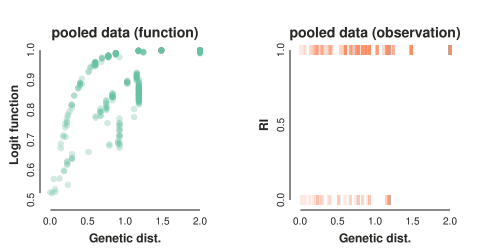

In [637]:
logit_plot(SAMPLE);

### Pairwise RI heatmap of sparse crossing data

In [652]:
def heatmap_plot(TREE, CLADES, data):
    
    # get canvas size
    canvas = toyplot.Canvas(width=500, height=500);

    # colormap for values between 0-1
    cmap_lower = toyplot.color.LinearMap(
        domain_min=data['logit'].min(), 
        domain_max=data['logit'].max()
    )

    # add tree to canvas
    ax0 = canvas.cartesian(
        bounds=("5%", "25%", "5%", "95%"),
        show=False
    )
    TREE.draw(
        axes=ax0, 
        layout='r', 
        tip_labels=False,
        edge_colors=TREE.get_edge_values_mapped({
            j: toytree.colors[i] for i,j in enumerate(CLADES)
        })
    )
    NSPECIES = TREE.ntips

    # add heatmap to canvas
    ax1 = canvas.table(
        rows=NSPECIES, 
        columns=NSPECIES, 
        bounds=("27%", "88%", "5%", "95%"),
        margin=20
    )
    ax1.cells.cell[:].style = {
        "fill": 'lightgrey',
        "stroke": "none"
    }

    # set values for data
    for idx in data.index:
        ridx, cidx = data.loc[idx, ['sidx0', 'sidx1']]
        rridx = NSPECIES - ridx - 1
        ccidx = NSPECIES - cidx - 1
        ridx, cidx, rridx, ccidx = [
            int(i) for i in (ridx, cidx, rridx, ccidx)
        ]

        # get RI for this cell
        value = data.loc[idx, 'logit']
        ax1.cells.cell[rridx, cidx].style = {
            "fill": cmap_lower.color(value),
            "stroke": "none"
        }
        fill = ("white" if data.at[idx, 'RI'] == 1 else "#262626")
        ax1.cells.cell[ccidx, ridx].style = {
            "fill": fill,
            "stroke": "none"
        }
            
    for idx in range(NSPECIES):
        ax1.cells.cell[NSPECIES - idx - 1, idx].style = {
            "fill": cmap_lower.color(0),
            "stroke": "none"
        }

    # dividers
    ax1.body.gaps.columns[...] = 0.5
    ax1.body.gaps.rows[...] = 0.5
    
    # add a colorbar
    numberline = canvas.numberline("92%", "95%", "92%", "5%")
    numberline.colormap(cmap_lower, style={"stroke-width": 5})

    return canvas

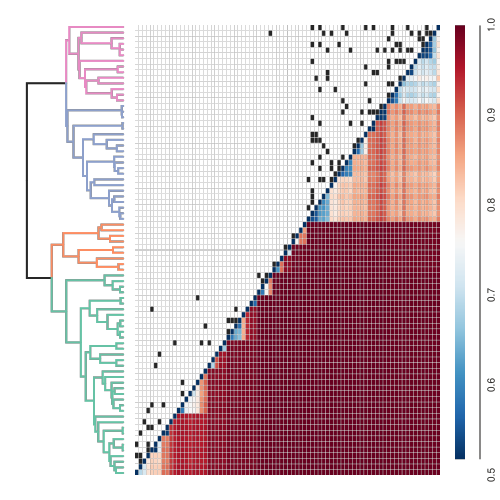

In [653]:
heatmap_plot(TREE, CLADES, DATA)

# Bayesian model fitting

### Function to plotting posterior traces

In [654]:
def toytrace(trace, var_names, titles):
    """
    Plot posterior trace with toyplot
    """
    nvars = len(var_names)
    
    # setup canvase
    canvas = toyplot.Canvas(width=500, height=200 * nvars)
    
    # store axes
    axes = []
    
    # iter over params
    for pidx, param in enumerate(var_names):
        
        # get param posterior
        posterior = trace.get_values(param)
        
        # setup axes 
        ax = canvas.cartesian(grid=(nvars, 1, pidx))
        ax.y.show = False
        ax.x.spine.style = {"stroke-width": 1.5}
        ax.x.ticks.labels.style = {"font-size": "12px"}
        ax.x.ticks.show = True
        ax.x.label.text = f"param='{titles[pidx]}'"        
        
        # iterate over shape of param
        for idx in range(posterior.shape[1]):
            mags, bins = np.histogram(posterior[:, idx], bins=100)
            ax.plot(bins[1:], mags, stroke_width=2, opacity=0.6)
        axes.append(ax)
    return canvas, axes

<h2><i>Setup <span style="color:red">partially-pooled</span> model</i></h2>

Fit a different RI velocity to every species, but drawn from a hyperprior distribution for the clade/group they belong to.


$$ \psi_g \sim \mathcal{N}(\mu_g, \sigma^2_g) $$

$$ \text{RI}_{i,j} = \alpha + (\beta + \psi_{g,i} + \psi_{g,j})X_{i,j} + \sigma $$

$$ Y_{ij} = \frac{1}{1 + exp^{-(\alpha + (\beta + \psi_i + \psi_j)X_{ij})}} $$


In [656]:
def fit_model(x, y, idx0, idx1, gidx, **kwargs):
       
    # define model
    with pm.Model() as model:
        
        # indexers
        sidx0 = pm.Data("spp_idx0", idx0)
        sidx1 = pm.Data("spp_idx1", idx1)
        gidx = pm.Data("gidx", gidx)

        # parameters and error
        𝜓_mean = pm.Normal('𝜓_mean', mu=0., sigma=5., shape=4)
        𝜓_std = pm.HalfNormal('𝜓_std', 5., shape=4)
        𝜓_offset = pm.Normal('𝜓_offset', mu=0, sigma=1., shape=NSPECIES)
        𝜓 = pm.Deterministic('𝜓', 𝜓_mean[gidx] + 𝜓_std[gidx] * 𝜓_offset)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        
        # linear model prediction
        effect = 𝛼 + (𝛽 + 𝜓[sidx0] + 𝜓[sidx1]) * x
        logit = pm.Deterministic("logit", pm.invlogit(effect))
        
        # data likelihood (normal distributed errors)
        y = pm.Bernoulli("y", p=logit, observed=y)

        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]

        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

### MCMC Sample Parameters

In [657]:
# MCMC sampler kwargs
sample_kwargs = dict(
    tune=10000,
    draws=10000,
    target_accept=0.99,
    return_inferencedata=False,
    progressbar=True,
)

### Fit models to data generated under the part-pooled model

In [659]:
# model input
model_args = [
    data.dist,
    data.RI,
    data.sidx0,
    data.sidx1,
    SPECIES_DATA.gidx,
]

In [660]:
partpooled = fit_model(*model_args, **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 19835 seconds.


### Examine results

In [670]:
partpooled['stats']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
𝜓_mean[0],1.381,2.254,-2.831,5.631,0.021,0.015,11643.0,18846.0,1.0
𝜓_mean[1],0.830,2.290,-3.441,5.145,0.021,0.015,11982.0,19224.0,1.0
𝜓_mean[2],-0.297,2.247,-4.566,3.848,0.021,0.015,11616.0,18175.0,1.0
𝜓_mean[3],-0.790,2.249,-5.053,3.366,0.021,0.015,11660.0,18638.0,1.0
𝜓_offset[0],0.026,0.954,-1.751,1.839,0.003,0.006,83646.0,24235.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[3155],0.964,0.322,0.357,1.590,0.001,0.001,52273.0,32495.0,1.0
mu[3156],1.155,0.397,0.374,1.896,0.002,0.001,48029.0,32652.0,1.0
mu[3157],1.020,0.325,0.411,1.649,0.002,0.001,46590.0,31623.0,1.0
mu[3158],1.227,0.397,0.490,2.005,0.002,0.001,51996.0,33430.0,1.0


In [671]:
partpooled['trace'].varnames

['𝜓_mean', '𝜓_std_log__', '𝜓_offset', '𝛽', '𝛼', '𝜓_std', '𝜓', 'mu']

In [683]:
RI_ESTIMATE = (
    partpooled['trace']['𝛽'] + 
    partpooled['trace']['𝜓_mean'][:, SPECIES_DATA.gidx] + 
    partpooled['trace']['𝜓_std'][:, SPECIES_DATA.gidx] * 
    partpooled['trace']['𝜓_offset']
).mean(axis=0)

In [774]:
SPECIES_DATA

,gidx,𝛽,𝜓
0,0,3.056419,0.993487
1,0,3.012939,1.127949
2,0,2.917280,1.064483
3,0,3.126613,0.949807
4,0,2.561192,0.950889
...,...,...,...
75,3,2.720885,-1.019127
76,3,3.256690,-0.876676
77,3,2.738258,-1.017331
78,3,2.860949,-0.921553


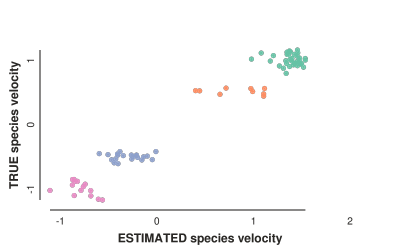

In [775]:
# show plot of TRUE vs. ESTIMATED rates
c, a, m = toyplot.scatterplot(
    partpooled['trace']['𝜓'].mean(axis=0),         # estimated
    SPECIES_DATA['𝜓'],                             # true
    width=400,
    height=250,
    xlabel="ESTIMATED species velocity",
    ylabel="TRUE species velocity",
    color=[toyplot.color.Palette()[i] for i in SPECIES_DATA.gidx],
);

<div class='alert alert-info'>
This is clearly able to separate out species to assign each a velocity according to their clade of origin, and it correctly identifies the order of velocities TRUE fast clades match ESTIMATED fast clades. 
</div>

### Rate variation among clades

In [787]:
partpooled['trace']['𝜓_std'][:, 0].std()

0.2849445132767703

In [781]:
partpooled['trace']['𝜓'].shape

(36000, 80)

In [746]:
stats.norm.interval(0.95, loc=0, scale=1)

(-1.959963984540054, 1.959963984540054)

(2.6971334584436732, 4.494881047524807)

In [736]:
import scipy.stats as stats

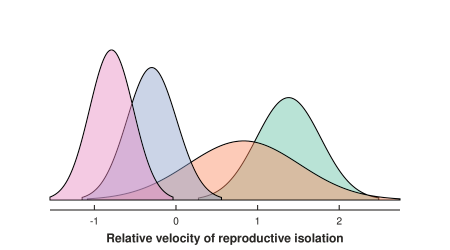

In [802]:
def draw_velocity_dists(trace):
    
    canvas = toyplot.Canvas(width=450, height=250)
    axes = canvas.cartesian(xlabel="Relative velocity of reproductive isolation")
    marks = []
    for i in range(trace['𝜓_mean'].shape[1]):
        loc = trace['𝜓_mean'][:, i].mean()
        scale = trace['𝜓_std'][:, i].mean()
        interval = stats.norm.interval(0.995, loc, scale)
        points = np.linspace(interval[0], interval[1], 100)
        mark = axes.fill(
            points, 
            stats.norm.pdf(points, loc=loc, scale=scale), 
            style={
                "fill-opacity": 0.45,
                "stroke": 'black',
                "stroke-opacity": 1.0,
                "stroke-width": 1,
            },
        )
        marks.append(mark)
    axes.y.show = False
    axes.x.ticks.locator = toyplot.locator.Extended(only_inside=True)
    axes.x.ticks.show = True
    return canvas, axes, marks
    
    
draw_velocity_dists(trace);

### Generate IMPUTED ESTIMATE FIGURE

In [803]:
# trace = partpooled['trace']
# IMPUTED = DATA.copy()
# IMPUTED["velo"] = (
#     trace['𝛽'].mean() + 
#     trace['𝜓_mean'][:, SPECIES_DATA.gidx] + 
#     trace['𝜓_std'][:, SPECIES_DATA.gidx] * 
#     trace['𝜓_offset']
# )
# #IMPUTED["intercept"] = trace['𝛼'].mean()
# #IMPUTED["logit"] = 1 / (1 + np.exp(-IMPUTED["intercept"] + IMPUTED['velo'] * IMPUTED['dist']))
# #IMPUTED

In [804]:
# heatmap_plot(TREE, CLADES, )

## Show Model Graphs

In [214]:
# pm.model_to_graphviz(pooled['model'])

In [215]:
# pm.model_to_graphviz(unpooled['model'])

In [216]:
# pm.model_to_graphviz(partpooled['model'])